<a href="https://colab.research.google.com/github/DavoodSZ1993/Dive_into_Deep_Learning/blob/main/11_2_attention_pooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==1.0.0-alpha1.post0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.0 MB/s eta 0:00:00


## 11.2 Attention Pooling by Similarity

In [2]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

d2l.use_svg_display()

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### 11.2.1 Kernels and Data

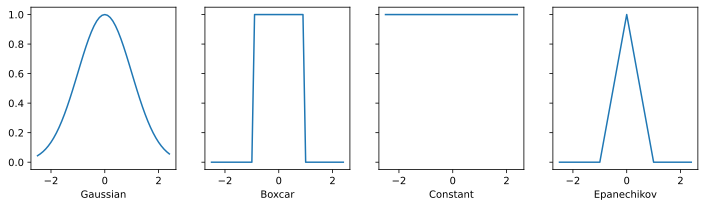

In [6]:
fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

def gaussian(x):
  return torch.exp(-x**2 / 2)

def boxcar(x):
  return torch.abs(x) < 1.0

def constant(x):
  return 1.0 + 0 * x

def epanechikov(x):
  return torch.max(1 - torch.abs(x), torch.zeros_like(x))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')

x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
  ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
  ax.set_xlabel(name)

In [7]:
def f(x):
  return 2 * torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

Text(0, 0.5, 'y_val')

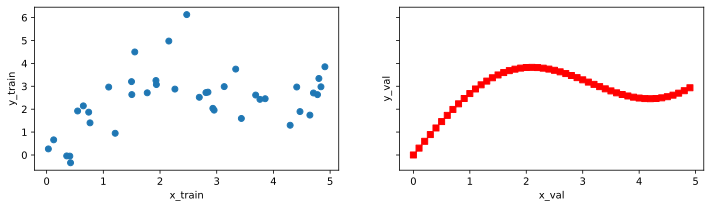

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

_, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

axes[0].scatter(x_train.detach().numpy(), y_train.detach().numpy(), marker='o')
axes[0].set_xlabel('x_train')
axes[0].set_ylabel('y_train')

axes[1].plot(x_val.detach().numpy(), y_val.detach().numpy(), marker='s', linestyle=':', color='r')
axes[1].set_xlabel('x_val')
axes[1].set_ylabel('y_val')

### 11.2.2 Attention Pooling via Nadaraya-Watson Regression

In [23]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
  dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
  # Each column/row corresponds to each query/key
  k = kernel(dists).type(torch.float32)
  attention_w = k / k.sum(0)   # Normalization over keys for each query
  y_hat = y_train @ attention_w
  return y_hat, attention_w

In [24]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
  fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
  for kernel, name, ax in zip(kernels, names, axes):
    y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
    if attention:
      pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
    else:
      ax.plot(x_val, y_hat)
      ax.plot(x_val, y_val, 'm--')
      ax.plot(x_train, y_train, 'o', alpha=0.5);
    if not attention:
      ax.legend(['y_hat', 'y'])
  if attention:
    fig.colorbar(pcm, ax=axes, shrink=0.7)

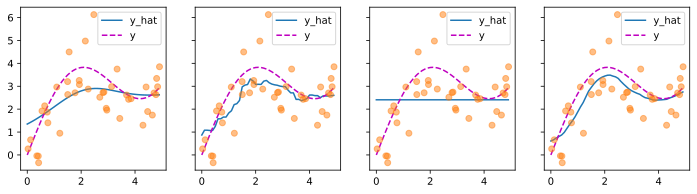

In [25]:
plot(x_train, y_train, x_val, y_val, kernels, names)

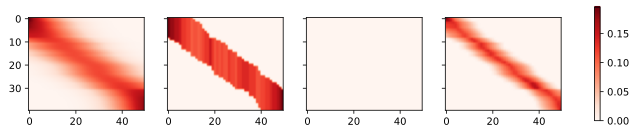

In [26]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)